### Code to run bichromatical images for restoration
In this notebook we will look at the bichromatical transformations and their denoising through Markov Chain Methodology.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
import os, sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [3]:
def display_images(orig, restored):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.imshow(orig); ax1.set_title('Noisy Input'); ax1.axis('off')
    ax2.imshow(restored); ax2.set_title('Restored Output'); ax2.axis('off')
    plt.show()

(300, 400, 3)


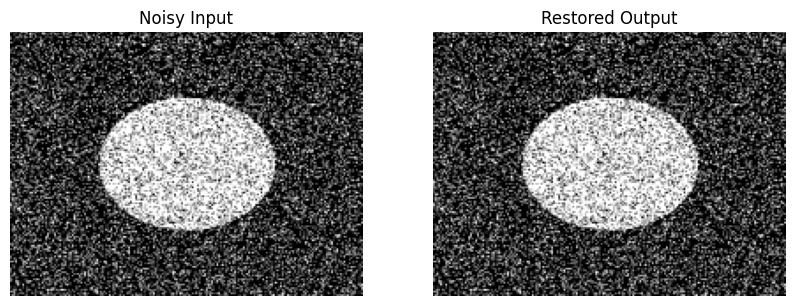

In [4]:
noisy_path = Path('..','Data', 'Transformed', 'bichromatical_noised', 'circle.png')
noisy = cv2.imread(noisy_path, cv2.IMREAD_COLOR)
noisy = cv2.cvtColor(noisy, cv2.COLOR_BGR2RGB)
# print(noisy.shape)
#resize to 300x400
noisy = cv2.resize(noisy, (400, 300), interpolation=cv2.INTER_AREA)
print(noisy.shape)
downscale_factor = 0.5
noisy = cv2.resize(
    noisy,
    (0, 0),
    fx=downscale_factor,
    fy=downscale_factor,
    interpolation=cv2.INTER_AREA
)
if noisy is None:
    raise FileNotFoundError(f"Cannot load image at {noisy_path}")
# Display noisy input
display_images(noisy, noisy)

In [ ]:
import numpy as np
from MarkovObjects.GibbsEstimator import (
    LpLoss, LorentzianLoss, SparseGradientPrior,
    WindowPatternTerm, GridMRF, GibbsSampler
)

# pick your loss, prior and (optional) window
loss = LorentzianLoss(sigma=1)
prior = SparseGradientPrior(p=1)
window = WindowPatternTerm(noisy, window_size=3, n_components=5)

# build the MRF
mrf = GridMRF(noisy, loss, prior,
               lambda_r=5.0,    
               window_term=None,
               lambda_w=0.0,
               neighbor_offsets=[(-1,0),(1,0),(0,-1),(0,1)],
               binary_map=True
             )


In [8]:
# run Gibbs
num_iter = 100
betas = 1.0
sampler = GibbsSampler(mrf, num_iter=num_iter, burn_in=num_iter * 0.4, verbose=True, estimate_mode='map', pior_type_for_optimal='potts', betas_T=betas)
sampler.fit_optimised(parallel_channels=False, shuffle_pixels=True, binary_map=True)
denoised = sampler.estimate()

[Channel 0][Iter 10] Loss=6234.03, Energy=5028246.01
[Channel 0][Iter 20] Loss=5974.12, Energy=4623582.51
[Channel 0][Iter 30] Loss=5879.65, Energy=4463328.20
[Channel 0][Iter 40] Loss=5754.77, Energy=4291031.49
[Channel 0][Iter 50] Loss=5807.07, Energy=4350142.74
[Channel 0][Iter 60] Loss=6010.61, Energy=4661656.97
[Channel 0][Iter 70] Loss=5902.36, Energy=4518405.85
[Channel 0][Iter 80] Loss=5755.98, Energy=4278019.72
[Channel 0][Iter 90] Loss=5921.41, Energy=4465371.96
[Channel 0][Iter 100] Loss=5771.39, Energy=4270027.13


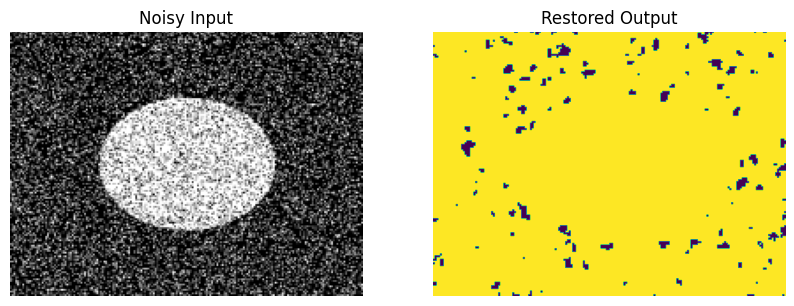

In [7]:
display_images(noisy, denoised)